# <b>Training Emotion Detector<b/>

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

In [ ]:
# importing libraries
import os
import cv2
import random

import numpy as np
import pandas as pd

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import layers,applications
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D

In [ ]:
# to not get tensed over unnecessary warning we will ignore them
import warnings
warnings.filterwarnings('ignore')

### <b>Simple EDA</b>

Let us do some analysis on the dataset we have. We have around 35887 images among which 28709 belong to train set and 7178 belong to test set having 7 classes each. The classes are Angry, Disgust, Fear, Happy, Neutral, Sad and Surprise. The dataset can be downloaded from https://www.kaggle.com/msambare/fer2013.

Let me show some example images from each category.

In [ ]:
# specifying the image size we want to input in model
picture_size=48

In [ ]:
# specifying the path where the data is stored
folder_path = '/content/'           # please change the folder path where data is stored when running locally

In [ ]:
# lsit of all classes
classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

angry
disgust
fear
happy
neutral
sad
surprise


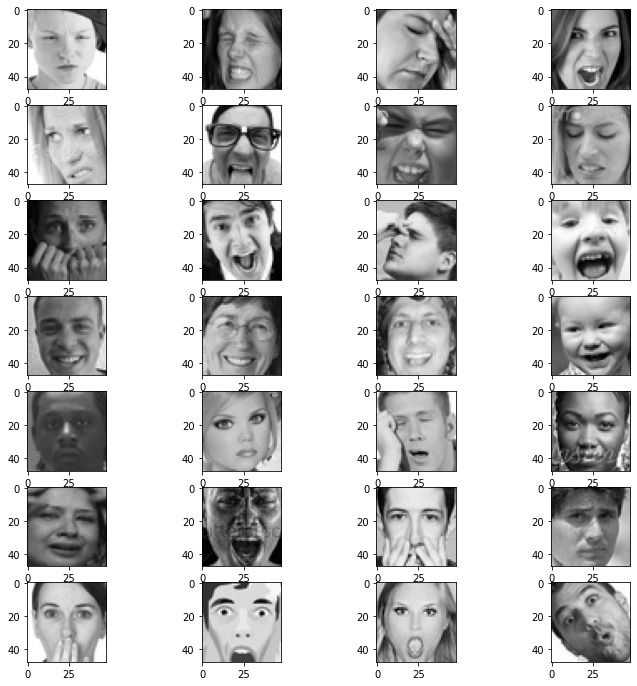

(48, 48, 3)


In [ ]:
# viewing some of the images from each category
plt.figure(figsize= (12,12))
i=1
for category in classes:
  for j in range(1,5):
    plt.subplot(7,4,i)
    img = load_img(folder_path+"train/"+category+"/"+
                  os.listdir(folder_path + "train/" + category)[j], target_size=(picture_size, picture_size))
    plt.imshow(img)
    i+=1
  print(category) 
plt.show()
x=img_to_array(img)
print(x.shape)

Let's look at the distribution of photographs in each of the training set's categories.

In [ ]:
# finding the count of images in each category
category=[]
examples=[]
for i in classes:
    dir='train/'+i
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    category.append(i)
    examples.append(len(onlyfiles))

In [ ]:
# creating a dataframe for the count of images
example_count_df=pd.DataFrame(category,columns=['Category'],index=[1,2,3,4,5,6,7])
example_count_df['No. of images']=examples
example_count_df

,Category,No. of images
1,angry,3995
2,disgust,436
3,fear,4097
4,happy,7215
5,neutral,4965
6,sad,4830
7,surprise,3171


Text(0.5, 1.0, 'Count of images in each category')

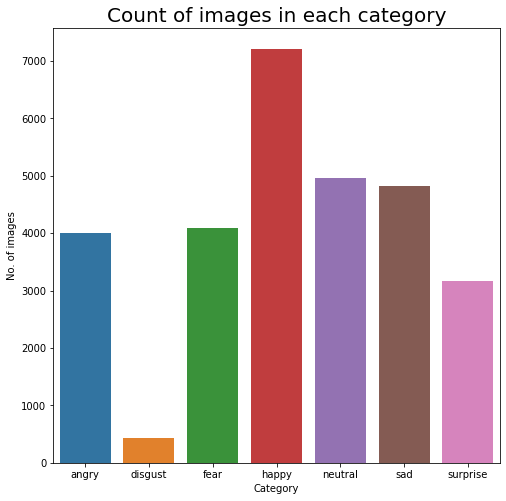

In [ ]:
# visualizing
plt.figure(figsize=(8,8))
sns.barplot(x=example_count_df['Category'],y=example_count_df['No. of images'])
plt.title('Count of images in each category',fontsize=20)

The data set is skewed, as seen by the frequency plot. There are fewer than 500 'disgust' faces among the over 7000 happy faces. This indicates that with this data set, we may not be able to distinguish 'disgust' faces well.

### <b>Data preprocessing<b/>

One of the most crucial tasks is to handle high-quality data in order to feed it to the algorithms. Because neural networks are data-hungry models, it stands to reason that their performance would increase if we had more data to feed them. Augmentation is one of the strategies we may utilise to produce extra data.

Furthermore, we cannot just input a picture into the model; it must be turned into a tensor. As a result, the keras library's ImageDataGenerator function may be used to produce batches of tensor image data with real-time data augmentation.

Most of the time, the data is too large to fit into memory, therefore we transfer it in chunks or batches to maintain a balance between batch gradient descent and stochastic gradient descent. This is accomplished by using the 'flow from dictionary' function, which accepts a directory path and creates batches of enhanced data. Additionally, the data is normalised to improve the model's performance.

In [ ]:
# defining the train and test set 
batch_size  = 128

datagen_train  = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### <b>Building a CNN model</b>

Convolutional layers, pooling layers, and fully-connected (FC) layers are the three types of layers that make up the CNN. The input layer is flattened to a vector, and the output layer is utilised to display the output. A CNN architecture will be constructed when these layers are layered. The dropout layer and the activation function are two additional key factors in addition to these three layers.

The first layer in the design is the Convolution layer, which is utilised to extract various picture characteristics. A filter of a specific size is used to convolve an image. The dot product is calculated between the filter and the regions of the input picture with the highest contrast.

To reduce computational expenses, a Pooling layer is employed to lower the size of the convolved feature map. The most crucial information is also kept.

A fully linked layer is identical to a basic neural network layer. It is utilised to link the neurons between two layers and contains the weights and biases as well as the neurons. The last several layers of a CNN Architecture are generally positioned before the output layer.

We also have batch mormalization, which essentially normalises Z values and aids in the solution of vanishing and exploding gradient problems. Dropout layers are used to keep the model from overfitting, while activation functions are used to bring nonlinearity into the model.

The 'Softmax' activation is used in the output layer, which gives a probability for each class that adds up to 1. The model's forecast will be based on the class with the highest likelihood.

In [ ]:
# defining a CNN model
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

Here we will define a checkpoint for the model so that it continously monitors the model and checks for the validation accuracy and saves only the best model.

We also define the epochs which is basically model going through the entire dataset once.

In [ ]:
# defining a callback that will save the best model
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# defining no. of epoch
epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

### <b>Training the CNN model</b>

Here we will train our compiled model. We pass the training set for training and test set for validation. The model keeps on training and validating in a each run and saves that model which gives the highest validation accuracy.

In [ ]:
# Fitting and training the model
history = model.fit(train_set,
                        epochs=epochs,
                        validation_data = test_set,
                        callbacks=callbacks_list
                        )

Epoch 1/48
225/225 [==============================] - 584s 3s/step - loss: 1.8424 - accuracy: 0.2803 - val_loss: 2.0416 - val_accuracy: 0.1719

Epoch 00001: val_accuracy improved from -inf to 0.17191, saving model to model.h5
Epoch 2/48
225/225 [==============================] - 587s 3s/step - loss: 1.5611 - accuracy: 0.3955 - val_loss: 1.7626 - val_accuracy: 0.3488

Epoch 00002: val_accuracy improved from 0.17191 to 0.34884, saving model to model.h5
Epoch 3/48
225/225 [==============================] - 600s 3s/step - loss: 1.3975 - accuracy: 0.4646 - val_loss: 1.3350 - val_accuracy: 0.4996

Epoch 00003: val_accuracy improved from 0.34884 to 0.49958, saving model to model.h5
Epoch 4/48
225/225 [==============================] - 598s 3s/step - loss: 1.3093 - accuracy: 0.4992 - val_loss: 1.2718 - val_accuracy: 0.5210

Epoch 00004: val_accuracy improved from 0.49958 to 0.52104, saving model to model.h5
Epoch 5/48
225/225 [==============================] - 598s 3s/step - loss: 1.2478 - acc

Great! Our model has undergone extensive training. This basic model took hours to train. Imagine how long it would take to train if we used other deep CNN models like VGG, Resnet, mobilenet, and so on!

### <b>Evaluating and plotting the model</b>

In [ ]:
# loading the saved model
trained_model=load_model('model.h5')

In [ ]:
# evaluating the train set
trained_model.evaluate(train_set)

225/225 [==============================] - 114s 505ms/step - loss: 0.5553 - accuracy: 0.7947


[0.5552985072135925, 0.794663667678833]

In [ ]:
# evaluating the test set
trained_model.evaluate(test_set)

57/57 [==============================] - 28s 487ms/step - loss: 1.0227 - accuracy: 0.6649


[1.0227210521697998, 0.6649484634399414]

As we can see accuracy of our model on train set is almost 80% and for test set is 67%.

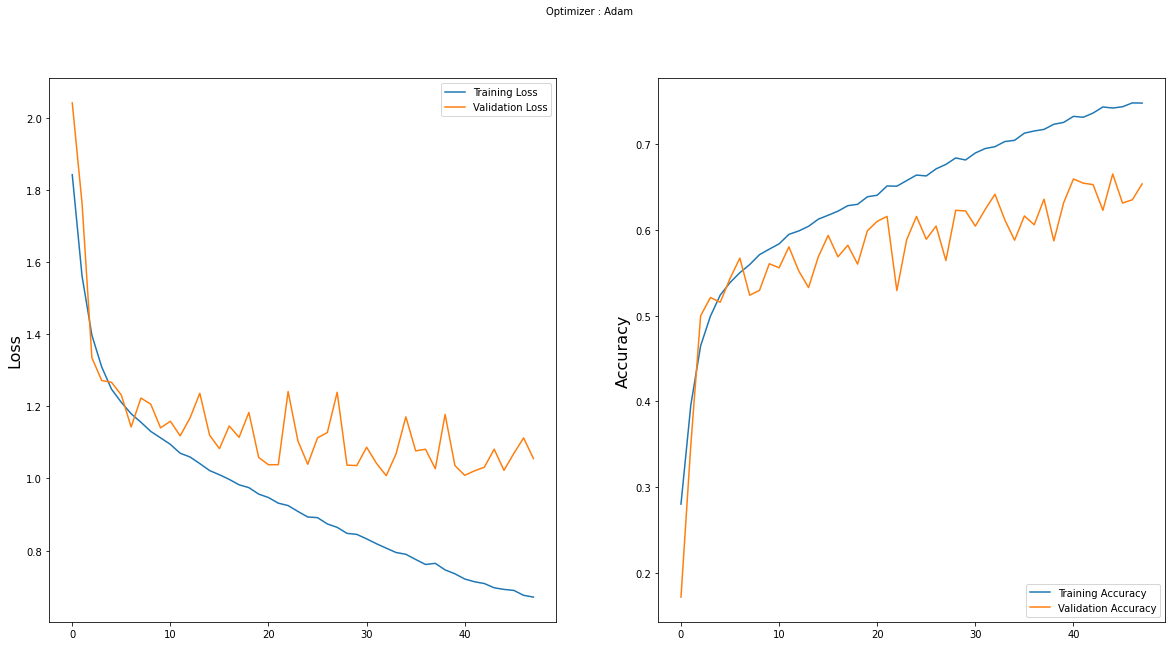

In [ ]:
# plotting the Loss for training and validation set
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plotting the Accuracy for training and validation set
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# <b>Testing some images<b/>

In [ ]:
# defining a classifier that detects faces in an image
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/1data/haarcascade_frontalface_default.xml')

In [ ]:
# some example images
test_examples = ['angry1.jpg','angry2.jpg','angry3.jpg','disgust1.jpg',
                 'disgust2.jpg','fear1.jpg','fear2.jpg','happy1.jpg',
                 'happy2.jpg','neutral1.jpg','neutral2.jpg','sad1.jpg',
                 'sad2.jpg','surprise1.jpg','surprise2.jpg']

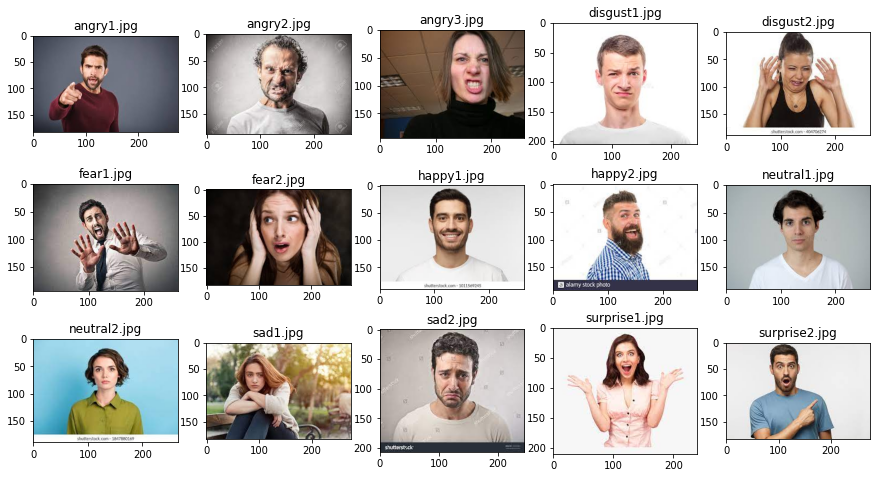

In [ ]:
# view these images
plt.figure(figsize=(15,8))
for i,j in enumerate(test_examples):
  frame=cv2.imread(j)
  plt.subplot(3,5,i+1)
  plt.title(j)
  plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
# defining emotion labels
emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']

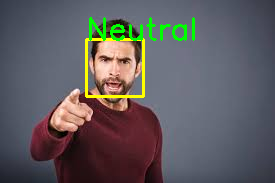

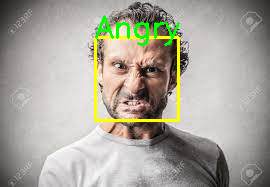

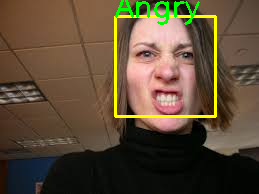

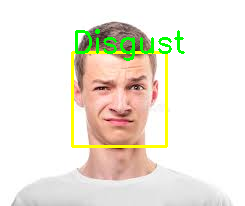

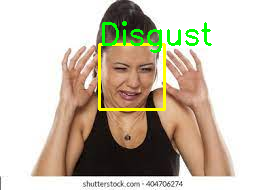

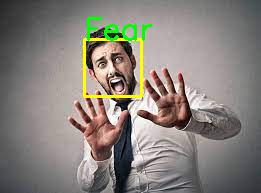

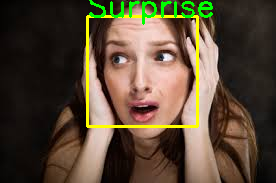

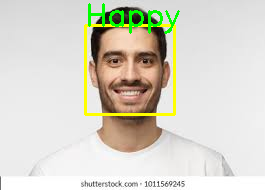

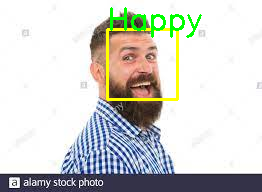

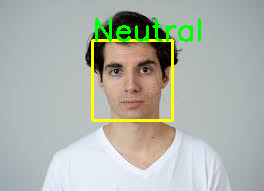

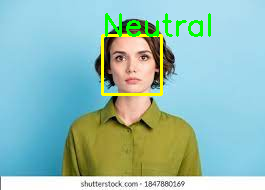

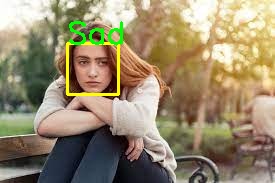

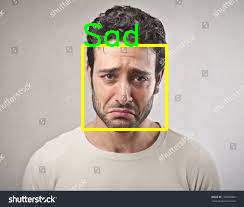

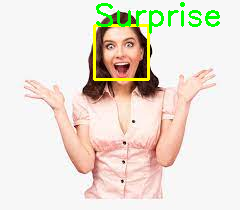

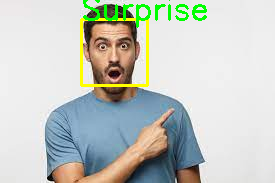

In [ ]:
# making predictions
for i in test_examples:
  frame=cv2.imread(i)
  gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray)

  for (x,y,w,h) in faces:
      cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
      roi_gray = gray[y:y+h,x:x+w]
      roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

      if np.sum([roi_gray])!=0:
          roi = roi_gray.astype('float')/255.0
          roi = img_to_array(roi)
          roi = np.expand_dims(roi,axis=0)

          prediction = trained_model.predict(roi)[0]
          label=emotion_labels[prediction.argmax()]
          label_position = (x,y)
          cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
      else:
          cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
  cv2.imshow(frame)

# Conclusion

That concludes the discussion. Our model has undergone extensive training.

We ended up with a train set accuracy of roughly 79 percent and a test set accuracy of around 67 percent. This can be regarded a worthwhile model because it requires less data to train and requires less computing resources.

The model's performance is not restricted to these statistics, as it always is. It can be improved by using deeper networks, transfer learning, tunings, and other techniques, but this will take more time and computing resources.